In [28]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Input, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog
from PIL import Image
from sklearn import svm
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# CNN

In [2]:
path = r"D:\CS Courses\CS4662\Project\train"
print(os.listdir(path))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'cat.10033.jpg', 'cat.10034.jpg', 'cat.10035.jpg', 'cat.10036.jpg', 'cat.10037.jpg', 'cat.10038.jpg', 'cat.10039.jpg', 'cat.1004.jpg', 'cat.10040.jpg', 'cat.10041.jpg', 'cat.10042.jpg', 'cat.10043.jpg', 'cat.10044.jpg', 'cat.10045.jpg', 'cat.10046.jpg', 'cat.10047.jpg', 'cat.10048.jpg', 'cat.10049.jpg', 'cat.1005.jpg'

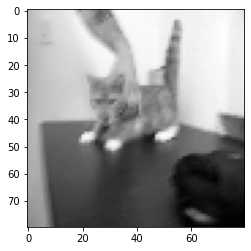

In [3]:
for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [4]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)

In [5]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)

In [6]:
#Normalize data
X = X/255.0

In [7]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Conv2D(16, (3,3), padding="same")(x)
    x = layers.Conv2D(16, (3,3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2,2))(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32,(3,3), padding="same")(x)
    x = layers.Conv2D(32,(3,3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2,2))(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64,(3,3), padding="same")(x)
    x = layers.MaxPooling2D(pool_size = (2,2))(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=X.shape[1:], num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer="adam",
               loss='binary_crossentropy',
               metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 80, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 40, 40, 16)        0         
                                                             

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)

In [10]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(16250, 80, 80, 1)
(8750, 80, 80, 1)
(16250,)
(8750,)


In [11]:
fitted_model = model.fit(X_train, y_train, batch_size=8, epochs=50, validation_split=0.2)

Epoch 1/50
1625/1625 [==============================] - 67s 41ms/step - loss: 0.6836 - accuracy: 0.5488 - val_loss: 0.6594 - val_accuracy: 0.6080
Epoch 2/50
1625/1625 [==============================] - 63s 39ms/step - loss: 0.6334 - accuracy: 0.6432 - val_loss: 0.5833 - val_accuracy: 0.7018
Epoch 3/50
1625/1625 [==============================] - 62s 38ms/step - loss: 0.5621 - accuracy: 0.7171 - val_loss: 0.5263 - val_accuracy: 0.7345
Epoch 4/50
1625/1625 [==============================] - 62s 38ms/step - loss: 0.5196 - accuracy: 0.7451 - val_loss: 0.4936 - val_accuracy: 0.7631
Epoch 5/50
1625/1625 [==============================] - 70s 43ms/step - loss: 0.4977 - accuracy: 0.7587 - val_loss: 0.4470 - val_accuracy: 0.7898
Epoch 6/50
1625/1625 [==============================] - 63s 39ms/step - loss: 0.4759 - accuracy: 0.7706 - val_loss: 0.4785 - val_accuracy: 0.7772
Epoch 7/50
1625/1625 [==============================] - 62s 38ms/step - loss: 0.4595 - accuracy: 0.7802 - val_loss: 0.4502 -

In [12]:
model.evaluate(X_test, y_test)

274/274 [==============================] - 5s 19ms/step - loss: 0.3151 - accuracy: 0.8625


[0.3151254653930664, 0.8625142574310303]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


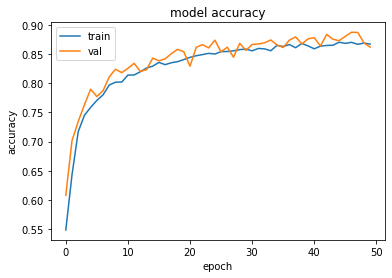

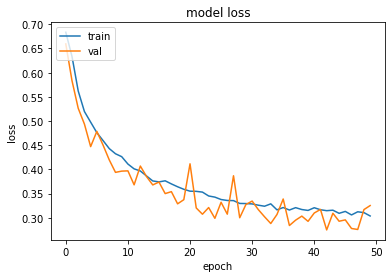

In [13]:
history_dict = fitted_model.history
print(history_dict.keys())

plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

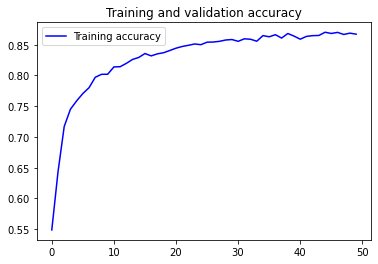

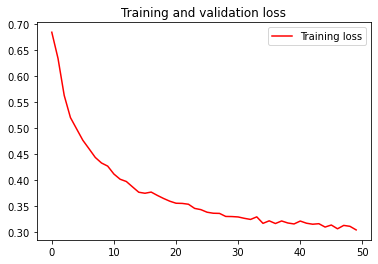

In [14]:
%matplotlib inline

accuracy = fitted_model.history['accuracy']
val_accuracy = fitted_model.history['val_accuracy']
loss = fitted_model.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
#plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.show()

### Using the "test1" dataset with our CNN and storing output in Submission.csv

In [15]:
path = os.path.join(r"D:\CS Courses\CS4662\Project\test1")
#os.listdir(path)

X_test = []
id_line = []
def create_test1_data(path):
    for p in os.listdir(path):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X_test.append(new_img_array)
create_test1_data(path)
X_test = np.array(X_test).reshape(-1,80,80,1)
X_test = X_test/255

In [16]:
predictions = model.predict(X_test)
predicted_val = [int(round(p[0])) for p in predictions]
submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val})
submission_df.to_csv("Submission.csv", index=False)

submission_df

,id,label
0,1,1
1,10,0
2,100,1
3,1000,1
4,10000,1
...,...,...
12495,9995,0
12496,9996,1
12497,9997,1
12498,9998,0


# Create feature matrix and label vector using "train" dataset

In [17]:
feature = []
label = []
img_names = []

for i in range(12500):
    # read cat image
    img = cv2.imread(f'train/cat.{i}.jpg')
    # resize image
    resized_img = cv2.resize(img, (128,64))
    # extract the features using HOG
    fd, hog_img = hog(resized_img, orientations = 9, pixels_per_cell = (8, 8), 
        cells_per_block = (2, 2), visualize = True, multichannel = True)
    # append feature array to feature list
    feature.append(fd)
    label.append(0)
    img_names.append(f'cat.{i}.jpg')
    
for i in range(12500):
    # read the dog image
    img = cv2.imread(f'train/dog.{i}.jpg')
    # resize image
    resized_img = cv2.resize(img, (128,64))
    # extract the features using HOG
    fd, hog_img = hog(resized_img, orientations = 9, pixels_per_cell = (8, 8), 
        cells_per_block = (2, 2), visualize = True, multichannel = True)
    # append feature array to feature list
    feature.append(fd)
    label.append(1)
    img_names.append(f'dog.{i}.jpg') 

In [18]:
X = feature
X

[array([0.24114294, 0.06173661, 0.01211721, ..., 0.02632917, 0.        ,
        0.        ]),
 array([0.2377736 , 0.01379087, 0.        , ..., 0.09364203, 0.07211129,
        0.06136094]),
 array([0.17491181, 0.06756563, 0.01408665, ..., 0.10353119, 0.05672069,
        0.04197485]),
 array([0.12112345, 0.00996073, 0.0356245 , ..., 0.14082789, 0.11449805,
        0.03203997]),
 array([0.2929974 , 0.2929974 , 0.23985301, ..., 0.02458975, 0.06991203,
        0.        ]),
 array([0.08325107, 0.10935514, 0.0838036 , ..., 0.00829886, 0.00476929,
        0.00359454]),
 array([0.03854878, 0.09046679, 0.08416502, ..., 0.27776602, 0.27776602,
        0.04018522]),
 array([0.2229061 , 0.0120247 , 0.        , ..., 0.10217072, 0.08439207,
        0.04167631]),
 array([0.26172136, 0.13596643, 0.14109218, ..., 0.00841692, 0.16591183,
        0.06820238]),
 array([0.08898515, 0.07601853, 0.03506896, ..., 0.03687808, 0.01738023,
        0.02304576]),
 array([0.06701156, 0.        , 0.24441563, ..., 0

In [19]:
y = label
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [20]:
# normalize
X_normal = preprocessing.scale(X)
X_normal

array([[ 0.72565569, -0.22136453, -0.96655938, ..., -0.92584277,
        -1.12814177, -0.9959354 ],
       [ 0.69200308, -0.86547452, -1.11121997, ..., -0.14162345,
        -0.17235255, -0.23150737],
       [ 0.0641469 , -0.1430567 , -0.94304738, ..., -0.02641115,
        -0.37634521, -0.4730172 ],
       ...,
       [ 1.48811868,  3.21435199,  1.54303528, ..., -0.75168836,
        -0.98427258, -0.52385183],
       [-0.16436224, -0.46144956,  2.4018392 , ...,  0.16350271,
        -0.14390877,  0.02423142],
       [-1.16282497, -0.53829155, -0.3998615 , ...,  1.76694305,
         0.8033943 ,  1.87161701]])

In [21]:
# Randomly splitting the original dataset into training set and testing set:
X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=0.25, random_state=5)

# print the size of the traning set:
print(np.asarray(X_train).shape)
print(np.asarray(y_train).shape)

# print the size of the testing set:
print(np.asarray(X_test).shape)
print(np.asarray(y_test).shape)

(18750, 3780)
(18750,)
(6250, 3780)
(6250,)


# SVM

In [22]:
# use PCA to reduce the dimensionality to 50
# fit PCA on training set only,
# then use the fitted model to transform both training and testing sets

from  sklearn.decomposition  import  PCA

k = 50  #  k  is the number of components (new features) after dimensionality reduction

my_pca = PCA(n_components = k)

# X_Train is feature matrix of training set before dimensionality reduction, 

# X_Train_New is feature matrix of training set after dimensionality reduction:

X_Train_new = my_pca.fit_transform(X_train)

X_Test_new = my_pca.transform(X_test)
print(X_Train_new.shape)
print(X_Test_new.shape)

(18750, 50)
(6250, 50)


In [23]:
# design and train a non-linear SVM classifier
my_svm = SVC(C=1, kernel='rbf', gamma=0.0005, random_state=1)

# Training ONLY on the training set:
my_svm.fit(X_Train_new, y_train)

# Testing on the testing set:
y_predict_svm = my_svm.predict(X_Test_new)
print(y_predict_svm)

[0 1 1 ... 1 1 1]


In [24]:
score_svm = accuracy_score(y_test, y_predict_svm)
print('SVM Accuracy:',score_svm)

SVM Accuracy: 0.76976


# Other ML Algorithms and Comparing with ROC Curves

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# "my_logreg" is instantiated as an "object" of LogisticRegression "class". 
my_logreg = LogisticRegression(max_iter=2000)

# Training ONLY on the training set:
my_logreg.fit(X_train, y_train)

# Testing on the testing set:
y_predict_lr = my_logreg.predict(X_test)

In [26]:
#calculate accuracy
lr_accuracy = accuracy_score(y_test, y_predict_lr)

print('Logistic Regression Accuracy:', lr_accuracy)

Logistic Regression Accuracy: 0.70384


In [29]:
y_predict_prob_lr = my_logreg.predict_proba(X_test)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)
AUC_lr = metrics.auc(fpr_lr, tpr_lr)
print("Logistic Regression AUC:", AUC_lr)

Logistic Regression AUC: 0.7749992038347822


### KNN

In [30]:
# KNeighborsClassifier is name of a "sklearn class" to perform "KNN Classification" 
from sklearn.neighbors import KNeighborsClassifier  

# "knn" is instantiated as an "object" of KNeighborsClassifier "class".
k = 3
knn = KNeighborsClassifier(n_neighbors=k) # name of the object is arbitrary!

# Training ONLY on the training set:
knn.fit(X_train, y_train)

# Testing on the testing set:
y_predict_knn = knn.predict(X_test)

In [31]:
# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_predict_knn)

print('KNN Accuracy:', knn_accuracy)

KNN Accuracy: 0.60624


In [32]:
y_predict_prob_knn = knn.predict_proba(X_test)
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, y_predict_prob_knn[:,1], pos_label=1)
AUC_knn = metrics.auc(fpr_knn, tpr_knn)
print("KNN AUC:", AUC_knn)

KNN AUC: 0.6611957060121789


### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

my_DecisionTree = DecisionTreeClassifier()

# Training ONLY on the training set:
my_DecisionTree.fit(X_train, y_train)

# Testing on the testing set:
y_predict_dt = my_DecisionTree.predict(X_test)

In [34]:
# Calculate accuracy
score_dt = accuracy_score(y_test, y_predict_dt)
print('Decision Tree Accuracy:', score_dt, '\n')

Decision Tree Accuracy: 0.57696 



In [35]:
y_predict_prob_dt = my_DecisionTree.predict_proba(X_test)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, y_predict_prob_dt[:,1], pos_label=1)
AUC_dt = metrics.auc(fpr_dt, tpr_dt)
print("Decision Tree AUC:", AUC_dt)

Decision Tree AUC: 0.5769482162878302


### AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier

my_AdaBoost = AdaBoostClassifier(n_estimators = 29, random_state=2)

# Training ONLY on the training set:
my_AdaBoost.fit(X_train, y_train)

# Testing on the testing set:
y_predict_ab = my_AdaBoost.predict(X_test)

In [37]:
score_ab = accuracy_score(y_test, y_predict_ab)

print('Accuracy:', score_ab, '\n')

Accuracy: 0.68064 



In [38]:
y_predict_prob_ab = my_AdaBoost.predict_proba(X_test)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, y_predict_prob_ab[:,1], pos_label=1)
AUC_ab = metrics.auc(fpr_ab, tpr_ab)
print("AUC:", AUC_ab)

AUC: 0.7418794475811477


### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

my_RandomForest = RandomForestClassifier(n_estimators = 20, bootstrap = True, random_state=2)

# Training ONLY on the training set:
my_RandomForest.fit(X_train, y_train)

# Testing on the testing set:
y_predict_rf = my_RandomForest.predict(X_test)

In [40]:
# Calculate accuracy
score_rf = accuracy_score(y_test, y_predict_rf)

print('Random Forest Accuracy:', score_rf, '\n')

Random Forest Accuracy: 0.66288 



In [41]:
y_predict_prob_RF = my_RandomForest.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_predict_prob_RF[:,1], pos_label=1)
AUC_rf = metrics.auc(fpr_rf, tpr_rf)
print("Random Forest AUC: " + str(AUC_rf))

Random Forest AUC: 0.7192030749692722


### Roc Curves

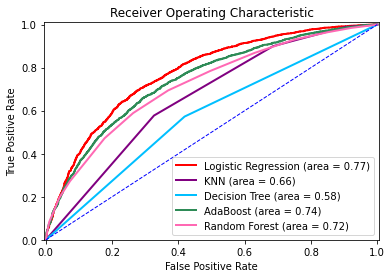

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, 
         label='Logistic Regression (area = %0.2f)' % AUC_lr)
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, 
         label='KNN (area = %0.2f)' % AUC_knn)
plt.plot(fpr_dt, tpr_dt, color='deepskyblue', lw=2, 
         label='Decision Tree (area = %0.2f)' % AUC_dt)
plt.plot(fpr_ab, tpr_ab, color='seagreen', lw=2, 
         label='AdaBoost (area = %0.2f)' % AUC_ab)
plt.plot(fpr_rf, tpr_rf, color='hotpink', lw=2, 
         label='Random Forest (area = %0.2f)' % AUC_rf)
# plt.plot(fpr_cnn, tpr_cnn, color='orange', lw=2, 
#          label='CNN (area = %0.2f)' % AUC_cnn)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()